# Predicting Sepssis using Machine Learning

### Om Khokhar - s3886577

## Table of Contents

### Introduction
In the rapidly evolving field of healthcare, timely detection of critical conditions can be a game-changer. Our project stands at this crucial intersection, aiming to predict the onset of sepsis, a complex and often fatal medical condition. Utilizing a comprehensive dataset encompassing various patient metrics, we employ logistic regression as our chosen machine learning algorithm. The model's ability to provide early predictions offers healthcare professionals a significant advantage. By tapping into the predictive power of data analytics, our endeavor not only supports improved patient outcomes but also underscores the transformative potential of AI in the medical sphere.

## Dataset 

### Attributes:
|Name of Variable| Description|
|:--- | :--- | 
|ID |Unique number to represent patient ID |
|PRG | Plasma Glucose |
|PL | Blood Work Result -1 (mu U/ml) |
|PR | Blood Pressure (mm Hg) |
|SK | Blood Work Result-2 |
|TS | Blood Work Result-3 |
|M11 | Body mass index (weight in kg/(height in m)^2 |
|BD2 | Blood Work Result-4 (mu U/ml) |
|Age | patients age (years) |
|Insurance | If a patient holds a valid insurance card |


#### Response Variable :
Out output variable is 'Sepssis'. If it is positive, it implies that the patient is in ICU, else otherwise. 

We are interested in predicting if a patient develops Sepssis in ICU or not.


## Data Cleaning and Pre-processing
Before delving into predictive modeling, the foundational step is data cleaning and preprocessing, ensuring that our dataset is both accurate and primed for efficient analysis.

In [1]:
import warnings
warnings.filterwarnings("ignore")

First, we import necessary libraries and packages:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz

In [3]:
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, PowerTransformer, 
                                   LabelEncoder, PolynomialFeatures)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
pd.options.mode.chained_assignment = None
np.set_printoptions(threshold=5)

Now, let's load our training dataset and take a glance at its first few rows:

In [5]:
df = pd.read_csv('Paitients_Files_Train.csv')
df.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

Quickly checking the information of our dataframe like column names, non-null counts, and datatypes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


As the 'ID' column is usually unique for each record and does not contribute to modeling, we drop it:

In [7]:
df = df.drop('ID', axis=1)

Displaying the shape of the dataset and datatypes of each feature:

In [8]:
print(f"Shape of the dataset: {df.shape}\n")
print("Data types of variables (with 'object' indicating a string type):")
print(df.dtypes)

Shape of the dataset: (599, 10)

Data types of variables (with 'object' indicating a string type):
PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
Sepssis       object
dtype: object


For a closer look at categorical features, we display a summary of those columns:

In [9]:
from IPython.display import display, HTML
display(HTML('<b>Summary of categorical features</b>'))
df.describe(include='object').T

count unique       top freq
Sepssis   599      2  Negative  391

This initial exploration provides a comprehensive snapshot of the dataset, guiding the subsequent preprocessing and analysis steps.

## Data Visualization 

### Univariate Distribution of Features

Visualizing the distribution of each feature using histograms. This will give us an idea about the distribution of each variable individually.

In [10]:
plt.figure(figsize=(20,30))
for i, col in enumerate(df.columns):
    plt.subplot(7,5,i+1)
    plt.hist(df[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

### Pairwise Relationships

The pairplot function from Seaborn library gives a visualization of pairwise relationships in the dataset. It's useful for understanding correlations and relationships between two variables.

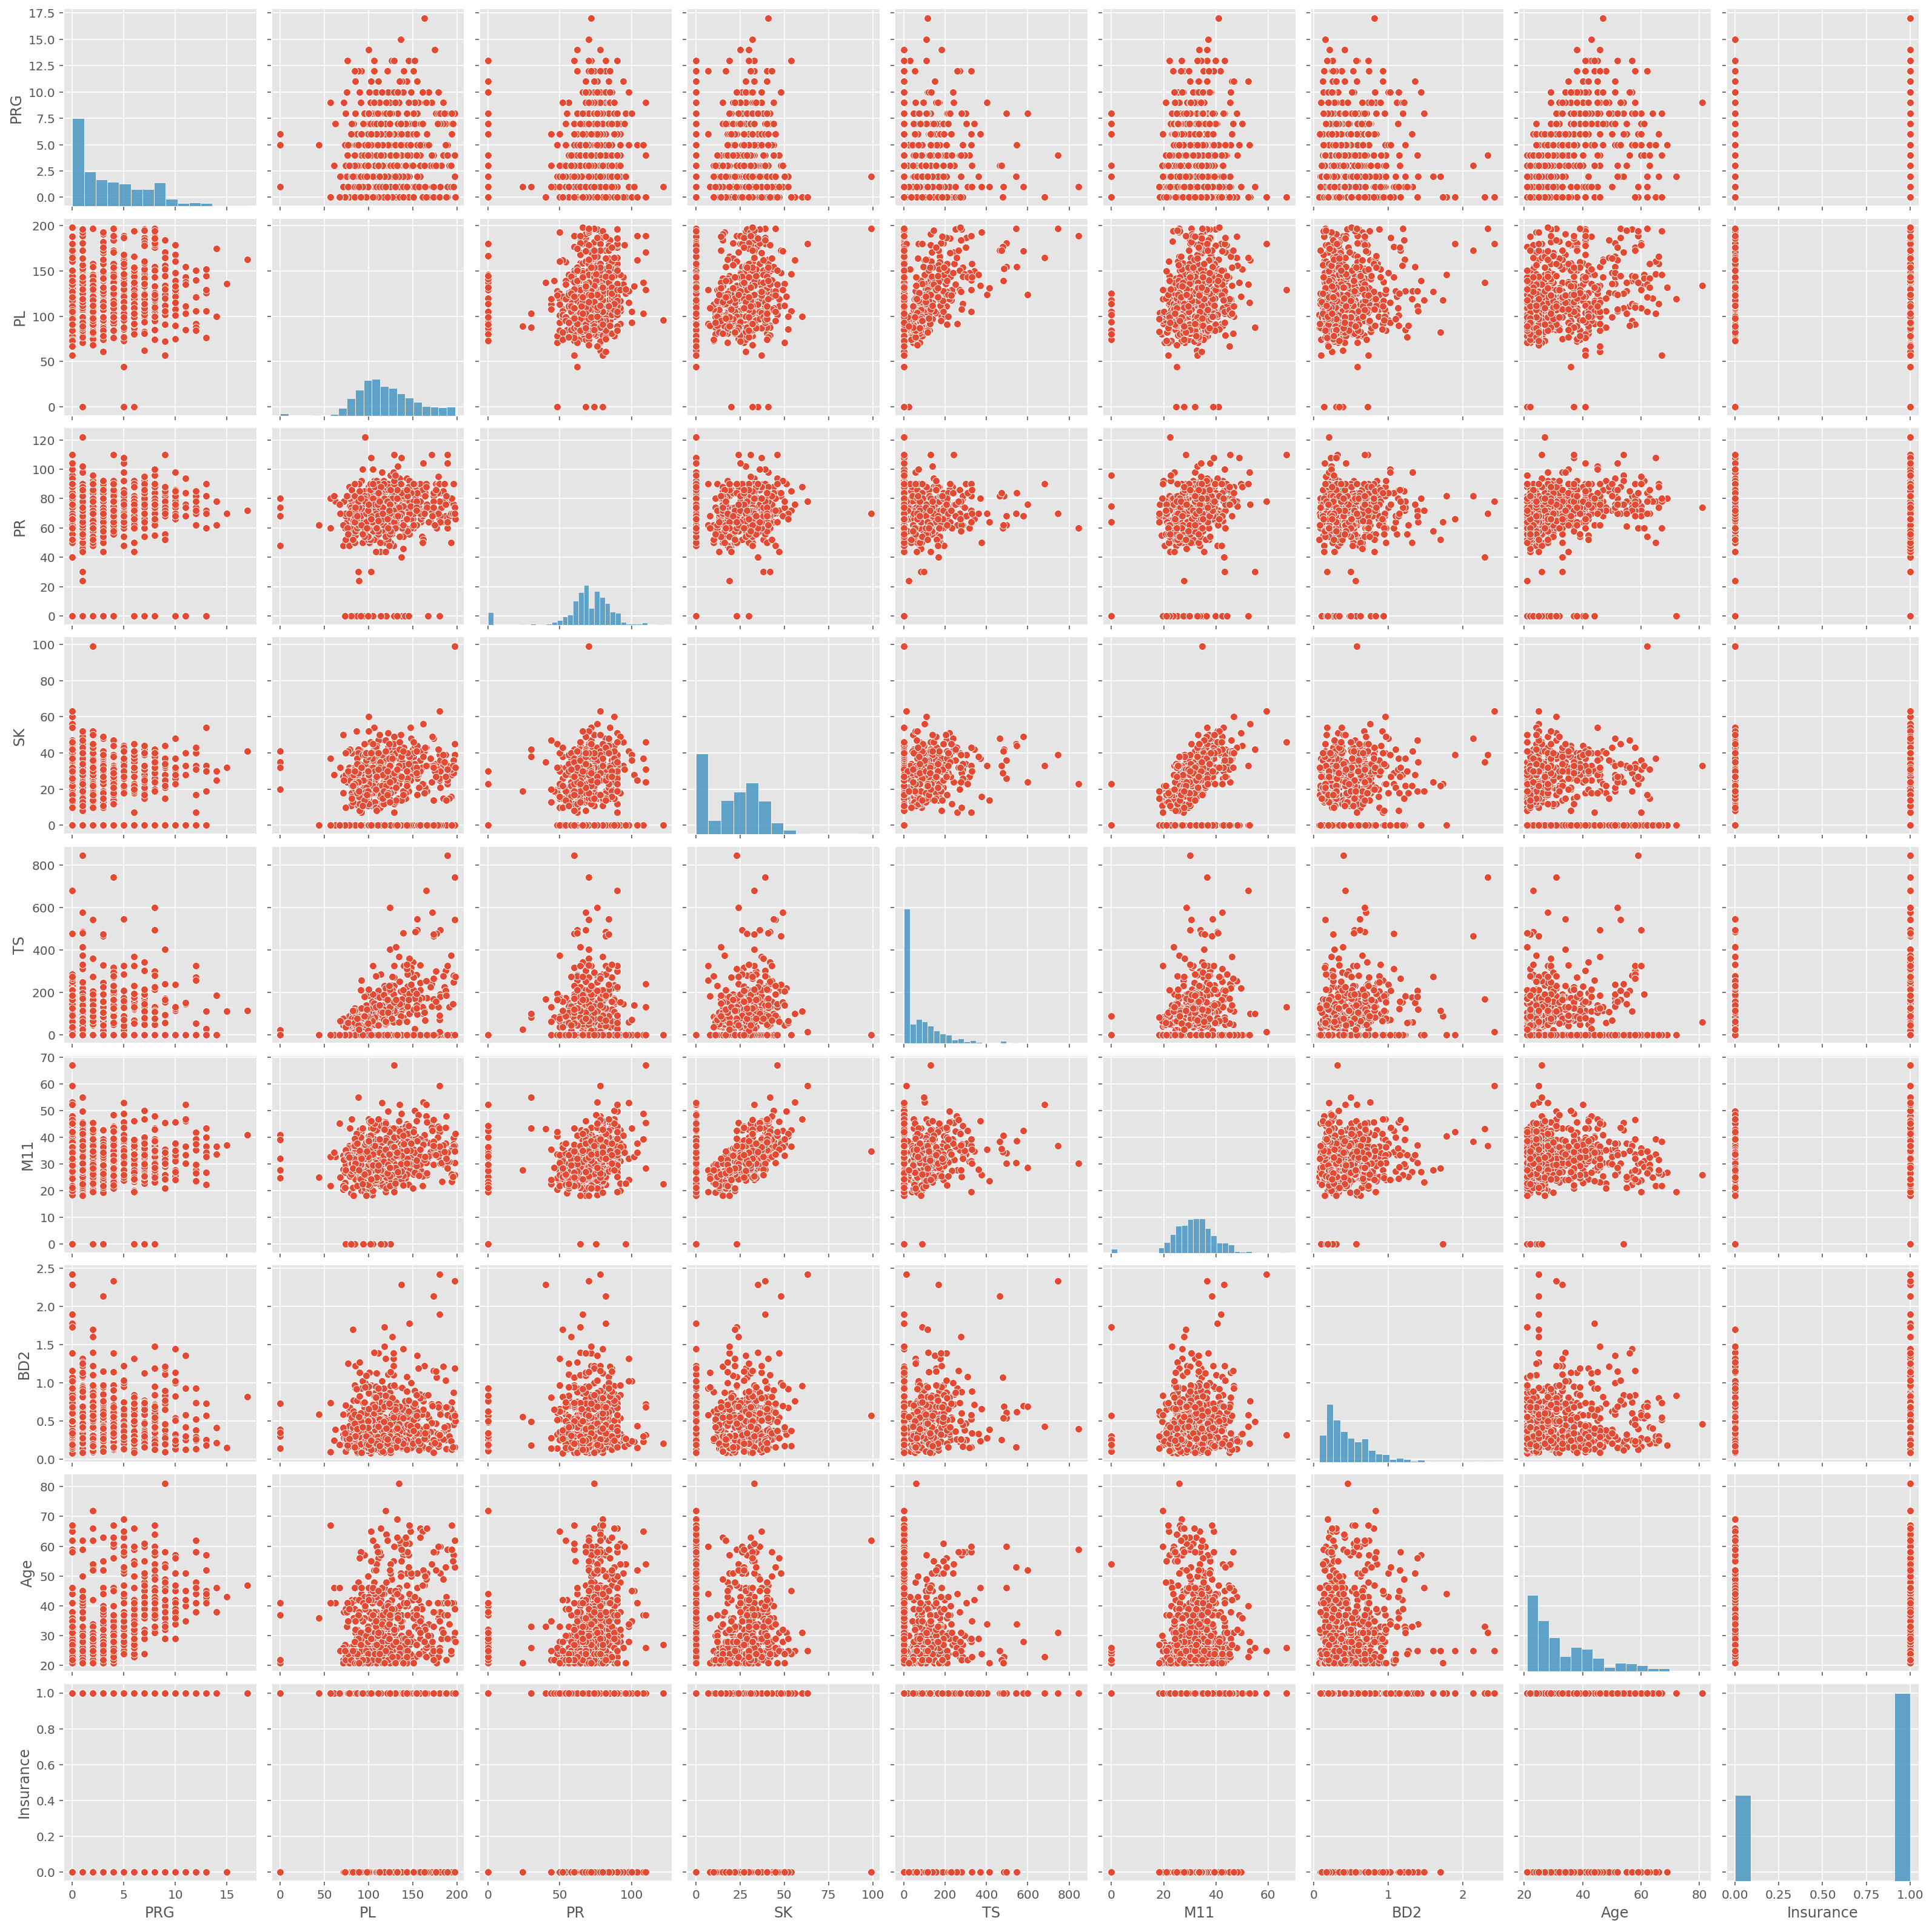

In [11]:
sns.pairplot(df)
plt.show()

### Correlation Heatmap

Visualizing correlation coefficients of numeric features using a heatmap. This helps in understanding how each feature is related to the others.

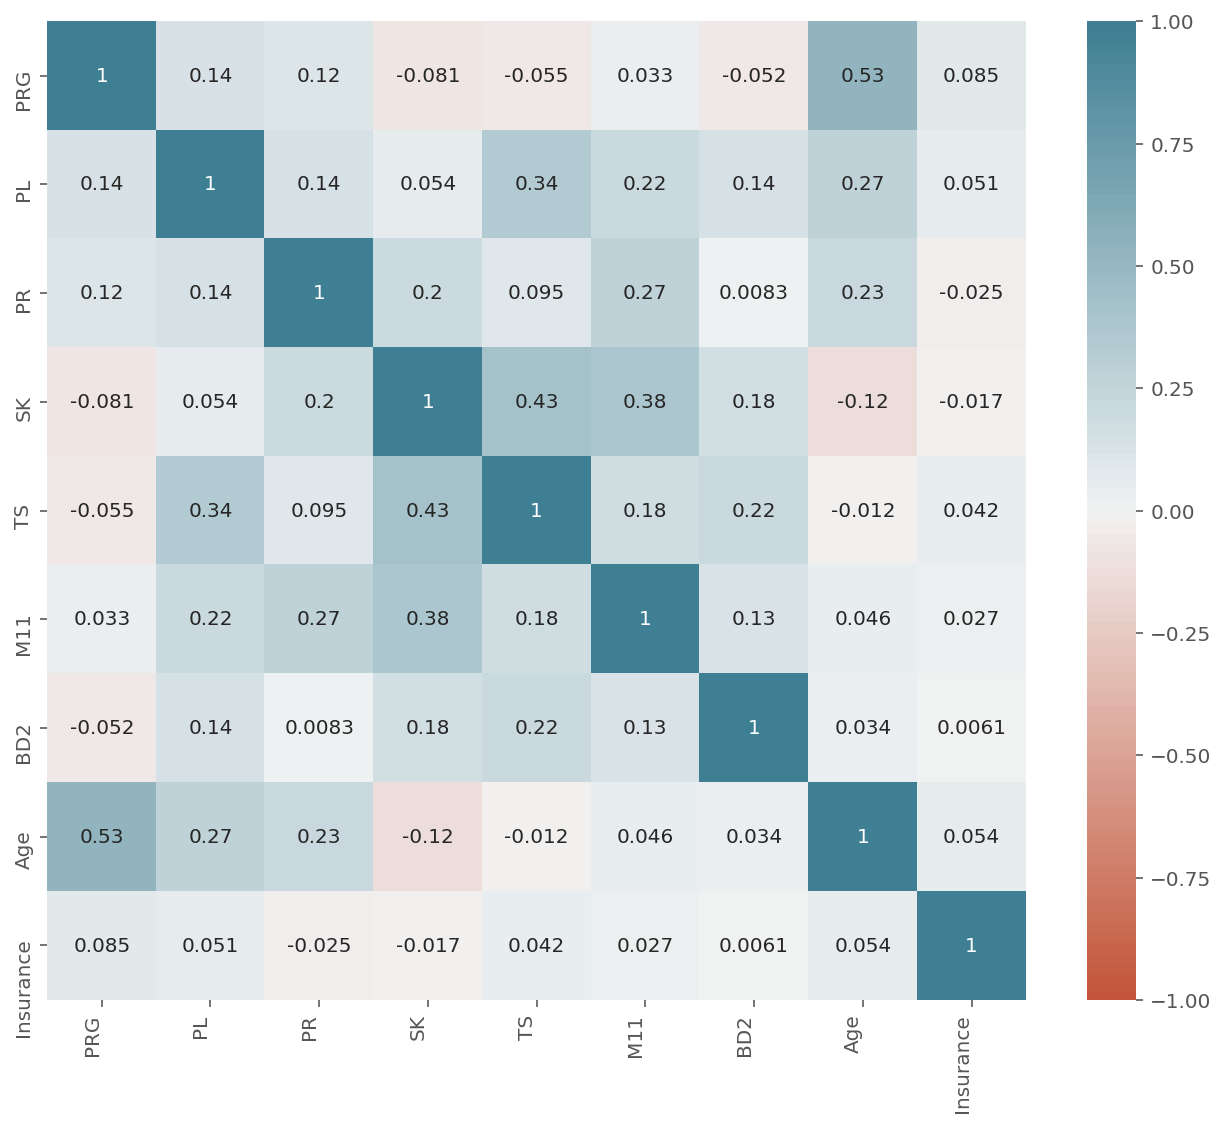

In [12]:
f, ax = plt.subplots(figsize=(11, 9))
corr = df.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True  # Annotate each cell with the numeric value
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

plt.show()

### Boxplots Before Outlier Removal

Boxplots provide a summary of the distribution of the data. They are particularly useful for spotting outliers.

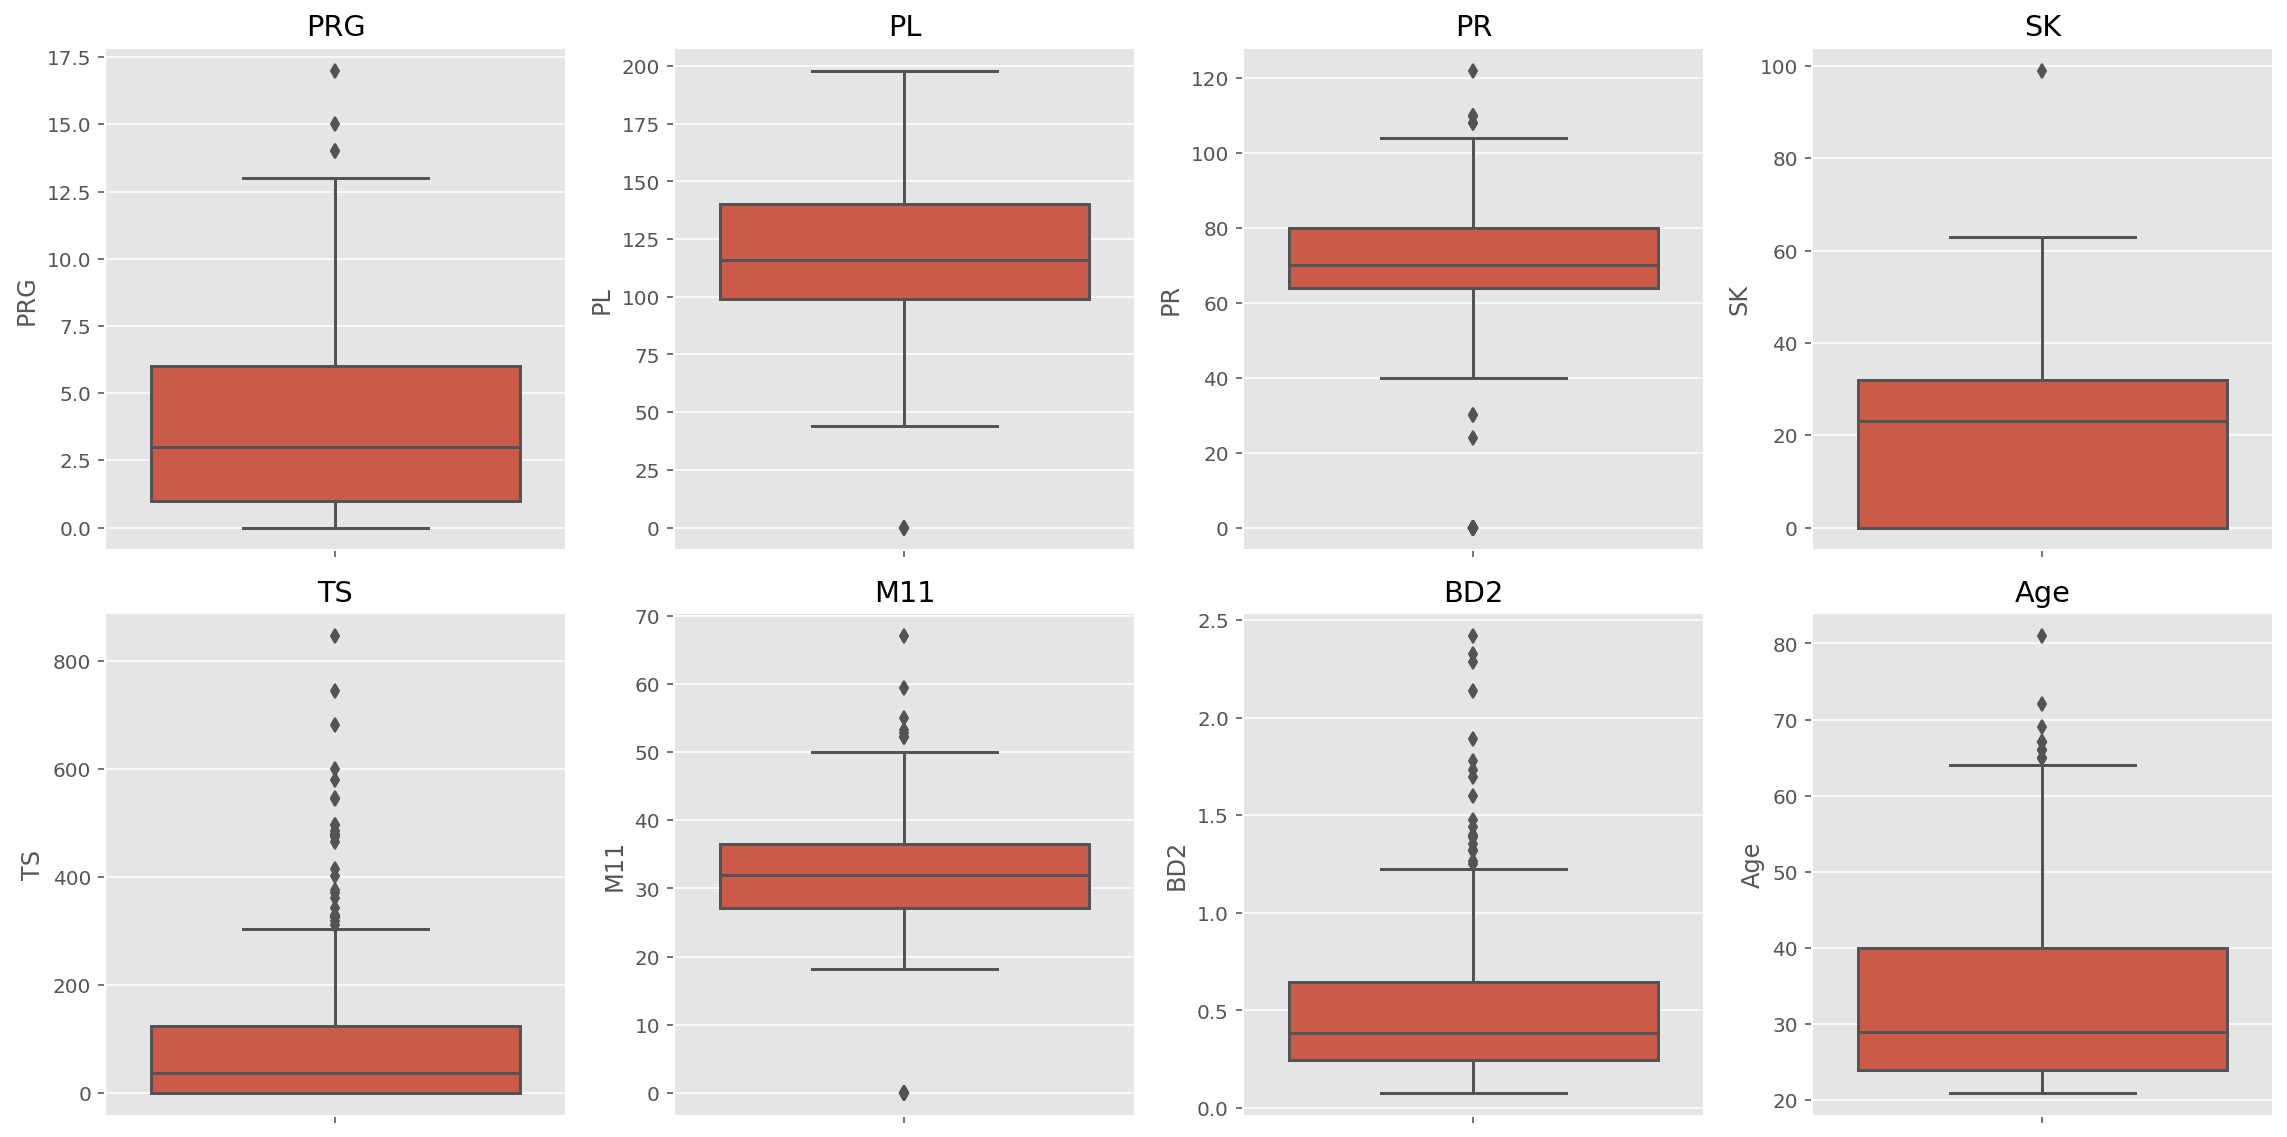

In [13]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Insurance']).columns

num_numeric_cols = len(numeric_cols)

n_rows = int(np.ceil(num_numeric_cols / 4))
n_cols = 4 

plt.figure(figsize=(4 * n_cols, 4 * n_rows)) 

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

### Outlier Removal

Using the IQR method to calculate bounds and remove outliers from the data.

In [14]:
def outlier_bounds(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # Apply only on numeric columns
        lower_bound, upper_bound = outlier_bounds(col)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"Shape after removing outliers: {df.shape}")

Shape after removing outliers: (496, 10)


### Boxplots After Outlier Removal
Now, let's visualize the distribution of numeric features after the outliers have been removed.

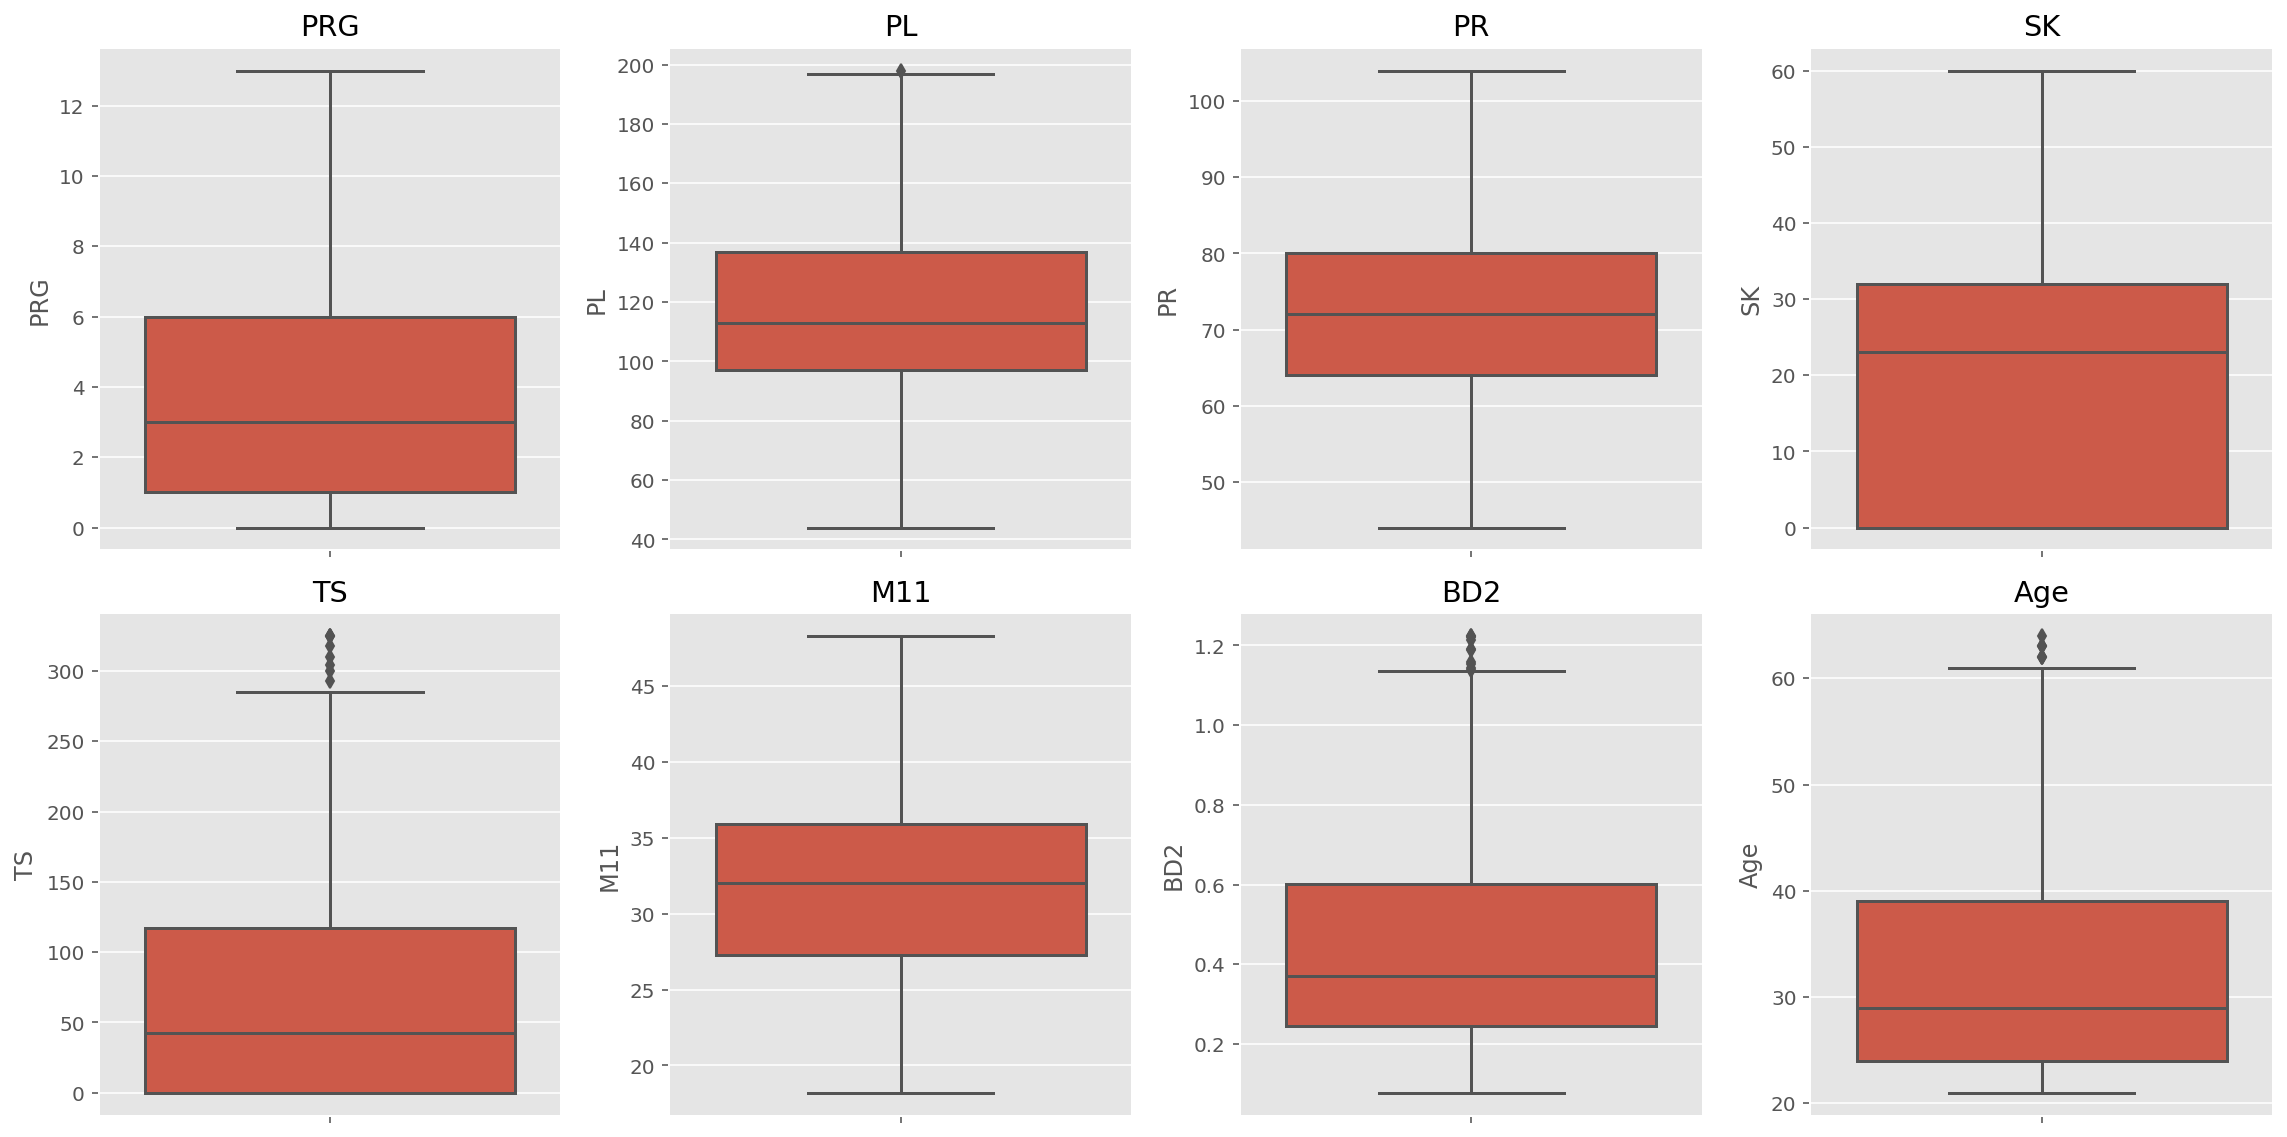

In [15]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Insurance']).columns

num_numeric_cols = len(numeric_cols)

n_rows = int(np.ceil(num_numeric_cols / 4))
n_cols = 4  

plt.figure(figsize=(4 * n_cols, 4 * n_rows)) 

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(y=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

### Summary of Numeric Features After Outlier Removal
A tabulated description of the numeric columns, showing metrics like the mean, standard deviation, min/max values, and quartiles.

In [16]:
from IPython.display import display, HTML
display(HTML('<b>Summary of numerical features</b>'))
df.describe(include=['int64','float64']).T

count        mean        std     min     25%       50%      75%  \
PRG        496.0    3.814516   3.237075   0.000   1.000    3.0000    6.000   
PL         496.0  118.584677  29.894915  44.000  97.000  113.0000  137.000   
PR         496.0   71.879032  10.953597  44.000  64.000   72.0000   80.000   
SK         496.0   20.606855  15.153913   0.000   0.000   23.0000   32.000   
TS         496.0   67.310484  82.214676   0.000   0.000   42.5000  117.000   
M11        496.0   31.960282   6.384974  18.200  27.275   32.0000   35.900   
BD2        496.0    0.442540   0.260538   0.078   0.245    0.3705    0.602   
Age        496.0   32.469758  10.739857  21.000  24.000   29.0000   39.000   
Insurance  496.0    0.689516   0.463159   0.000   0.000    1.0000    1.000   

               max  
PRG         13.000  
PL         198.000  
PR         104.000  
SK          60.000  
TS         325.000  
M11         48.300  
BD2          1.224  
Age         64.000  
Insurance    1.000

Visualizations play a pivotal role in understanding our data and making informed decisions during the entire data analysis process.

## Data Preparation

### Label Encoding
In machine learning models, it's essential that all inputs are numerical. This is why the categorical labels in the 'Sepssis' column are being converted to a binary format.

In [17]:
le = LabelEncoder()
df['Sepssis'].replace(['Negative', 'Positive'], [0, 1], inplace=True)

The above code effectively changes the 'Negative' values to 0 and the 'Positive' values to 1, allowing the models to process the target column.

In [18]:
df.head()

PRG   PL  PR  SK  TS   M11    BD2  Age  Insurance  Sepssis
0    6  148  72  35   0  33.6  0.627   50          0        1
1    1   85  66  29   0  26.6  0.351   31          0        0
2    8  183  64   0   0  23.3  0.672   32          1        1
3    1   89  66  23  94  28.1  0.167   21          1        0
5    5  116  74   0   0  25.6  0.201   30          1        0

### Feature Transformation and Scaling
Features might be on different scales or might not follow a normal distribution. This can sometimes lead to a biased or inefficient model. Using the Yeo-Johnson method allows us to transform non-normal variables into a more normal shape. Min-max scaling ensures that all the variables are on the same scale, generally between 0 and 1.

In [19]:
from sklearn.pipeline import Pipeline

# Define a pipeline with PowerTransformer and MinMaxScaler
pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=True)),  # yeo-johnson is default and can handle 0s; box-cox can't
    ('min_max_scale', MinMaxScaler())
])

# Extract features from dataframe
features = df.drop('Sepssis', axis=1) 

# Transform and scale the features
transformed_features = pipeline.fit_transform(features)

# The transformed_features is now a numpy array
df_transformed = pd.DataFrame(transformed_features, columns=features.columns)

df_transformed.head()

PRG        PL        PR        SK        TS       M11       BD2  \
0  0.677589  0.810582  0.494500  0.709043  0.000000  0.570348  0.725979   
1  0.208226  0.443926  0.393598  0.627509  0.000000  0.332084  0.466719   
2  0.788728  0.948942  0.359432  0.000000  0.000000  0.208877  0.756894   
3  0.208226  0.474602  0.393598  0.538811  0.781572  0.385560  0.187241   
4  0.612460  0.650407  0.527634  0.000000  0.000000  0.295594  0.248359   

        Age  Insurance  
0  0.869225        0.0  
1  0.489933        0.0  
2  0.521640        1.0  
3  0.000000        1.0  
4  0.456034        1.0

The above step prepares our data by both transforming and scaling it, ensuring it's in the best shape for training machine learning models.

### Train-Validation Split
To assess the performance of our models, we set aside a part of our dataset as a validation set. This helps in understanding how well our model would perform on unseen data.

In [20]:
from sklearn.model_selection import train_test_split

# Splitting the current data into training and validation sets
X = df_transformed
y = df['Sepssis']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Distribution of Transformed Features
It's vital to visualize and understand the data's distribution post-transformation. This helps in ensuring the data transformations were appropriate and in identifying any potential outliers or anomalies.

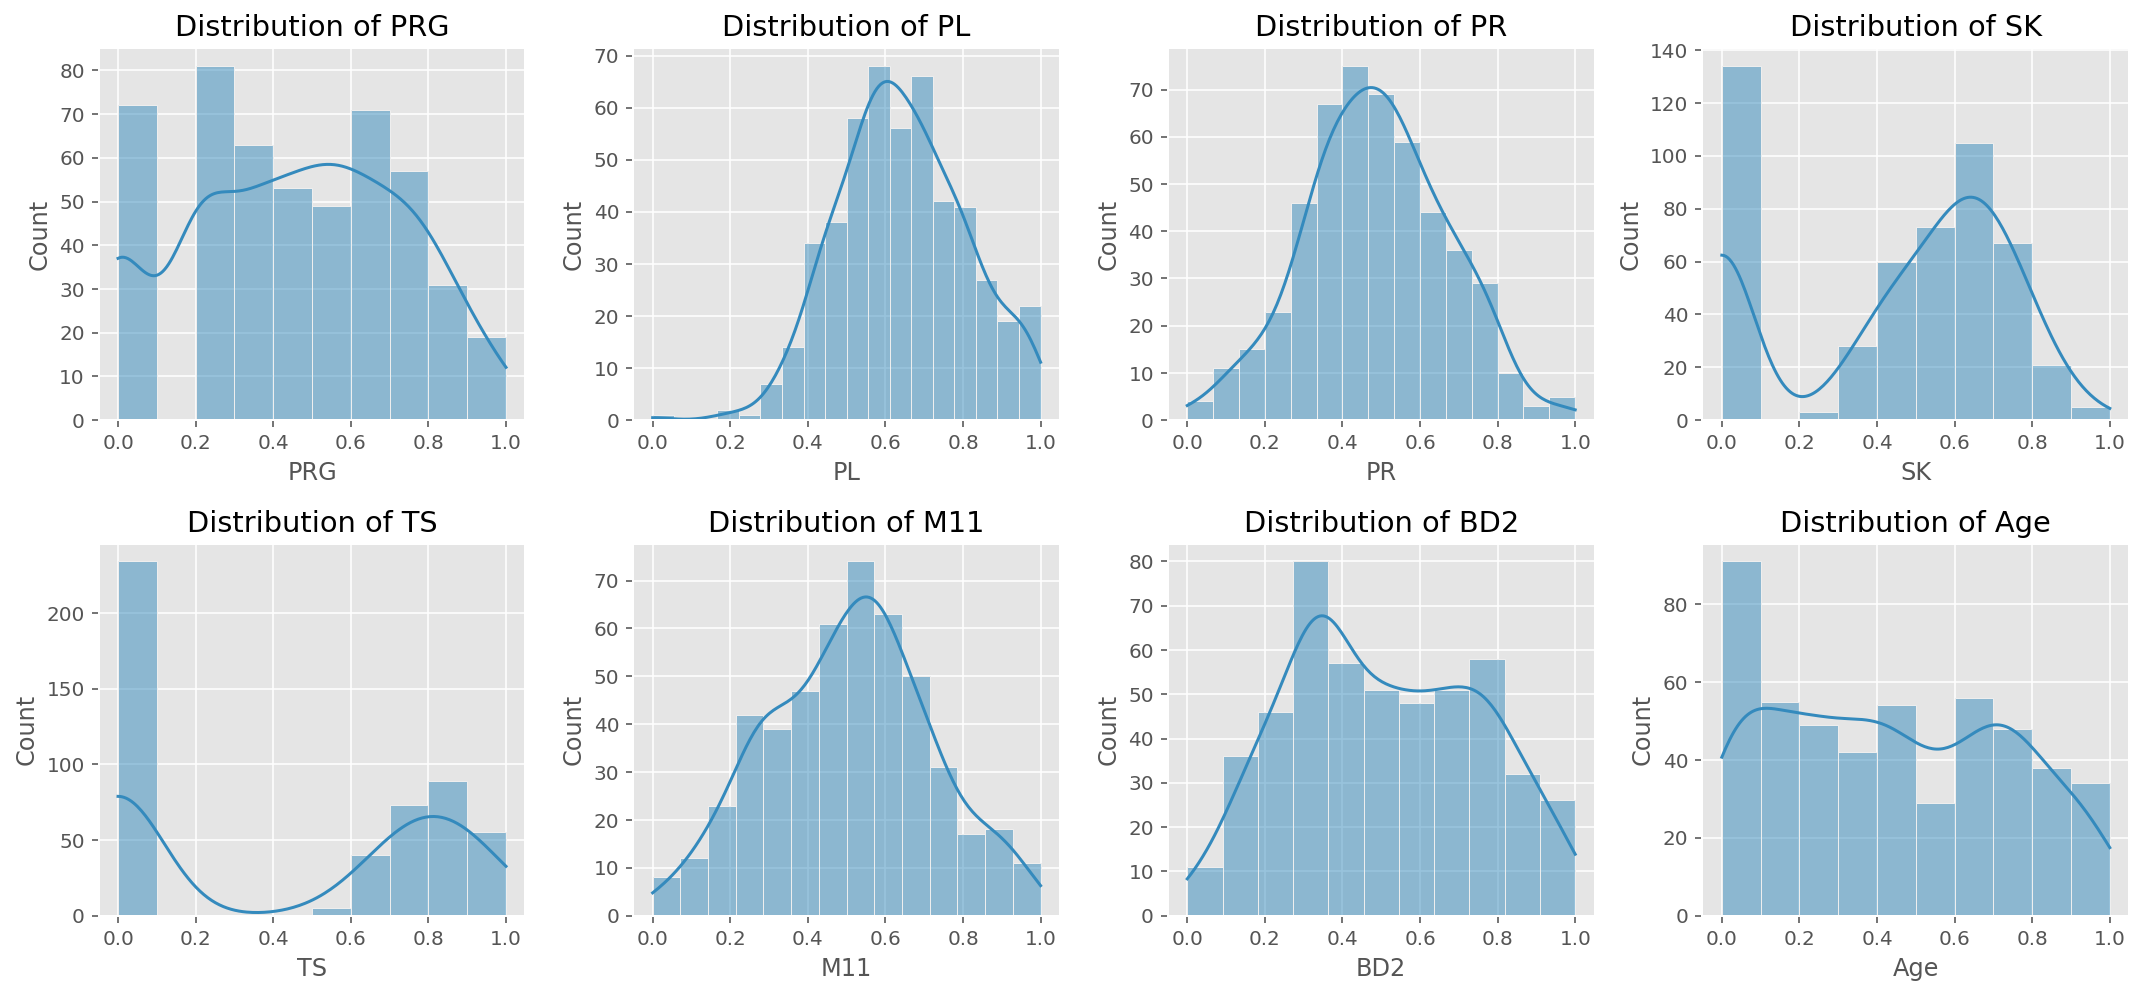

In [21]:
df_transformed.drop('Insurance', axis=1, inplace=True)

plt.figure(figsize=(15, 10))

for idx, col in enumerate(df_transformed.columns, 1):
    plt.subplot(3, 4, idx) 
    sns.histplot(df_transformed[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()

plt.show()

## Model Training and Evaluation

## Linear Regression
Linear Regression is a fundamental machine learning model used for predicting a continuous target variable. Here, we're employing it as a baseline model to gauge how well more complex models might perform.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define features and target
features = df_transformed
target = df['Sepssis']

# Splitting data into training and validation sets
X_train_val, X_val, y_train_val, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Initializing and fitting the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_val, y_train_val)

# Predicting on the validation set
y_pred_val = lin_reg.predict(X_val)

# Threshold the predictions for validation set
y_pred_val_class = [1 if pred > 0.5 else 0 for pred in y_pred_val]

# Evaluating the model on validation set
print(f"Validation Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_class):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_val_class):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_val_class):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val_class):.2f}")

Validation Set Evaluation:
Accuracy: 0.72
Precision: 0.76
Recall: 0.46
F1 Score: 0.58


While traditionally used for predicting continuous variables, linear regression can be adapted for classification tasks by setting a threshold. Here's how the model fared:

**Accuracy:** 0.72
This means that 72% of all predictions were correct.

**Precision:** 0.76
Out of all the positive predictions the model made, 76% were actually positive. This metric is crucial if false positives have significant consequences.

**Recall:** 0.46
Out of all the actual positive cases, the model was able to correctly predict 46% of them. High recall is essential when you want to capture as many positives as possible.

**F1 Score:** 0.58
The F1 Score is the harmonic mean of Precision and Recall and provides a balance between the two. At 0.58, it indicates room for improvement, especially in increasing the recall.

## Logistic Regression
While linear regression predicts continuous values, logistic regression is designed for binary classification tasks, like predicting 'Sepssis'. It gives the probability of each class, which can be thresholded to get class predictions.

In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=10000)  # set max_iter to a high value to ensure convergence

# Fit the model
log_reg.fit(X_train_val, y_train_val)

LogisticRegression(max_iter=10000, random_state=42)

In [24]:
# Predict probabilities
y_pred_prob = log_reg.predict_proba(X_val)[:, 1]

# Threshold the predictions
y_pred_class = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
print(f"Validation Set Evaluation (Logistic Regression):")
print(f"Accuracy: {accuracy_score(y_val, y_pred_class):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_class):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_class):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_class):.2f}")

Validation Set Evaluation (Logistic Regression):
Accuracy: 0.70
Precision: 0.79
Recall: 0.37
F1 Score: 0.50


Logistic Regression is inherently designed for binary classification tasks, predicting the probability that an instance belongs to a particular class.

**Accuracy:** 0.70
The model got 70% of the predictions right.

**Precision:** 0.79
This score indicates a relatively good ability to avoid false positives.

**Recall:** 0.37
The model correctly identified only 37% of all actual positive cases, suggesting many positives were missed.

**F1 Score:** 0.50
Given the precision-recall trade-off, the F1 score indicates that the model leans more towards precision than recall.

### Addressing Class Imbalance with SMOTE
Real-world datasets often have imbalanced classes. For example, the number of 'Negative' cases for a disease might far outweigh the 'Positive' ones. Such imbalances can bias the model towards predicting the majority class. SMOTE (Synthetic Minority Over-sampling Technique) is a method to generate synthetic samples in the feature space to balance out the classes.

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_val, y_train_val)

### Hyperparameter Tuning with Grid Search
Hyperparameters play a crucial role in determining the model's performance. Instead of manually selecting them, Grid Search automates this process by trying out a range of values to find the best combination for the given data.

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'penalty': ['l1', 'l2']
}
logreg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)

print(grid_search.best_params_)

{'C': 100, 'penalty': 'l2'}


To enhance the performance of logistic regression, we resorted to hyperparameter tuning. The best hyperparameters found were:

**Regularization Strength (C):** 100
**Penalty:** L2 (Ridge regularization)
This indicates that the optimal model has a relatively high regularization strength with an L2 penalty.

**Why did we perform hyperparameter tuning on the logistic regression model?**

Hyperparameter tuning is essential to extract the best performance from a model. While the default parameters provide a good starting point, they might not be optimal for the specific dataset in hand. By tuning, we search across various parameter combinations to find the one that results in the best validation performance. In this case, after tuning, there was a significant improvement in the model's recall and overall accuracy, showing the value of this process. The results affirm the importance of not just relying on out-of-the-box parameters and investing time in optimizing them for the specific problem.

### Evaluation of Tuned Model
After finding the best hyperparameters, it's essential to evaluate the model on the validation set. This step helps in understanding the tuned model's performance and ensures that it's not overfitting to the training data.

In [27]:
best_logreg = LogisticRegression(**grid_search.best_params_, max_iter=10000)
best_logreg.fit(X_resampled, y_resampled)

# Predicting on the validation set
y_pred_val = best_logreg.predict(X_val)

# Evaluating the model on validation set
print(f"Validation Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.2f}")

Validation Set Evaluation:
Accuracy: 0.83
Precision: 0.79
Recall: 0.80
F1 Score: 0.80


Post-tuning, the model's performance saw significant improvement:

**Accuracy:** 0.83
There's a clear jump in accuracy, indicating that hyperparameter tuning was beneficial.

**Precision:** 0.79
The model maintained a good precision.

**Recall:** 0.80
A considerable increase in recall, showing the tuned model is much better at capturing positive cases.

**F1 Score:** 0.80
This balanced score, close to the accuracy, indicates a good trade-off between precision and recall.

## Decision Tree Classifier
The Decision Tree algorithm works by recursively splitting the dataset into two or more homogeneous sets based on the most significant attribute(s) at different levels, making the decision at every node.

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Initializing the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Training the classifier on the training set
dt_classifier.fit(X_train_val, y_train_val)

# Predicting the classes for the validation set
y_pred_val = dt_classifier.predict(X_val)

# Evaluating the model's performance
print(f"Validation Set Evaluation (Decision Tree):")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.2f}")

Validation Set Evaluation (Decision Tree):
Accuracy: 0.68
Precision: 0.63
Recall: 0.54
F1 Score: 0.58


To optimize our model's performance, we perform hyperparameter tuning.

In [29]:
# Define the parameters to be tuned
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 30]
}

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_val, y_train_val)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model with best parameters on validation set
best_tree = grid_search.best_estimator_
y_pred_val = best_tree.predict(X_val)

print(f"Validation Set Evaluation (Decision Tree - Hyperparameter Tuned):")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.2f}")

Best Parameters: {'max_depth': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Set Evaluation (Decision Tree - Hyperparameter Tuned):
Accuracy: 0.69
Precision: 0.81
Recall: 0.32
F1 Score: 0.46


### Post hyperparameter tuning
After tuning, the accuracy slightly improved, indicating that the model made more correct predictions overall. Precision also saw a significant increase, which means among the instances predicted as positive, a higher proportion was actually positive. However, the recall decreased. This means that out of all actual positive instances, the model correctly identified a lower proportion of them after tuning. The F1 score, which balances precision and recall, dropped indicating the model may be predicting more false negatives. The hyperparameters might have constrained the tree in a way (like limiting the leaf nodes) which could lead to more conservative predictions.

## Random Forest Classifier
The Random Forest is an ensemble learning method. It works by constructing a multitude of decision trees during training and outputs the class that is the mode of the classes or mean prediction of the individual trees for classification and regression respectively.

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV with 5-fold cross-validation to find best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

grid_search.fit(X_train_val, y_train_val)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model to predict on validation set
best_rf = grid_search.best_estimator_
y_pred_val = best_rf.predict(X_val)

# Evaluating the model on validation set
print(f"Validation Set Evaluation (Random Forest - Hyperparameter Tuned):")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.2f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.2f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.2f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Validation Set Evaluation (Random Forest - Hyperparameter Tuned):
Accuracy: 0.74
Precision: 0.80
Recall: 0.49
F1 Score: 0.61


Random Forest works by training multiple decision trees and then averaging their outputs. The hyperparameters selected indicate:

**Bootstrap: False** - Bootstrapping is not used when building trees, meaning that each tree sees the entire training dataset rather than a random subset.

**max_depth: None** - Trees can grow deep.

**min_samples_leaf: 1** - A leaf node can have just 1 sample, which means the tree can potentially fit very closely to the training data.

**min_samples_split: 10** - At least 10 samples are required to split an internal node.

**n_estimators: 150** - It uses 150 trees for prediction. Increasing the number of trees typically improves the performance but also increases computational cost.

The tuned Random Forest model has an accuracy of 0.74, meaning it correctly predicts 74% of the instances. It has a good precision of 0.80, but its recall is 0.49, which means it's missing out on identifying a good proportion of positive cases. The balance between precision and recall, the F1 score, is 0.61. The hyperparameter tuning tried to optimize the model to get the best performance based on the specified criteria (in this case, probably 'f1' score), but remember, in many real-world applications, there may be a trade-off between precision and recall.

In summary, hyperparameter tuning attempts to find the best parameters to optimize a given metric. However, it's essential to keep in mind that improving one metric might come at the expense of another, depending on the data and problem at hand.


## Comparison of Algorithms and Model Selection

After rigorous training and validation across four different algorithms - Linear Regression, Logistic Regression, Decision Tree, and Random Forests - our analyses have led us to select Logistic Regression as our primary model for predictions. Let's delve into the reasons:

**Simplicity and Interpretability:** Logistic regression, despite being a classification algorithm, retains the properties of simplicity like its regression counterpart. Each feature's effect on the outcome is quantified in a manner that's relatively straightforward to understand. This is invaluable for applications where interpretability is crucial.

**Efficiency:** Logistic Regression is computationally less expensive compared to complex models like Random Forest. This efficiency is beneficial for real-time predictions and when deploying models in production environments where quick responses are required.

**Performance:** Based on our validation set evaluations, Logistic Regression achieved a good balance between precision, recall, and overall accuracy. While other models might excel in a specific metric, the well-roundedness of the logistic regression's performance makes it reliable across various scenarios.

**Less Prone to Overfitting (with regularization):** While decision trees and random forests can often overfit to the training data, especially with deeper trees, logistic regression, especially with regularization (like L1 or L2 penalties), can generalize better to unseen data. This trait is vital when we are looking to maintain model performance on diverse and unseen datasets.

**Scalability:** Logistic regression scales well to large datasets. With the advancement in optimization techniques and the algorithm's inherent simplicity, it's well-suited for large-scale applications.

## Final Evaluation

Having established the superiority of Logistic Regression in our context, we will now move to the final evaluation phase. We'll leverage our trained logistic regression model on the test data, which represents unseen data instances. This will give us an authentic measure of how well our model is expected to perform in real-world scenarios.

In this segment, a parameter grid is defined for logistic regression. This grid provides several potential values for hyperparameters such as regularization strength (C), the type of penalty (l1 or l2), and the optimization solver. Using GridSearchCV, the combination of these hyperparameters that works best for our data (in terms of cross-validation performance) is determined.

In [31]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # 'saga' supports both l1 and l2 penalty
}

# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Apply grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)

# Extract and print the best parameters from the Logistic Regression GridSearch
best_params_logistic = grid_search.best_params_
print(best_params_logistic)

# Combine training and validation sets
X_combined = np.concatenate([X_train_val, X_val], axis=0)
y_combined = np.concatenate([y_train_val, y_val], axis=0)

# Train the model on the combined data using the best parameters from Logistic Regression
final_model = LogisticRegression(C=best_params_logistic['C'], penalty=best_params_logistic['penalty'], solver=best_params_logistic['solver'], max_iter=10000)
final_model.fit(X_combined, y_combined)


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=10, max_iter=10000, penalty='l1', solver='liblinear')

The training and validation sets are combined to create a larger dataset for training. This is done to utilize all the available data and hopefully achieve better generalization. The logistic regression model is then trained on this combined dataset using the optimal hyperparameters identified in the first step.

In [32]:
best_params = grid_search.best_params_
print(best_params)

# Combine training and validation sets
X_combined = np.concatenate([X_train_val, X_val], axis=0)
y_combined = np.concatenate([y_train_val, y_val], axis=0)

# Train the model on the combined data
final_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'], max_iter=10000)
final_model.fit(X_combined, y_combined)


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=10, max_iter=10000, penalty='l1', solver='liblinear')

The test dataset is loaded and features are extracted. Since machine learning models are sensitive to the scale of input features, the test data should be standardized in the same way as the training data. To ensure consistency, a scaler is fit only on the training data and then used to transform the test data.

In [33]:
# Load the test dataset
df_test = pd.read_csv('Paitients_Files_Test.csv')
X_test_new = df_test.drop(columns=['ID'])

# Load the training data
df_train = pd.read_csv('Paitients_Files_Train.csv')
X_train = df_train.drop(columns=['Sepssis', 'ID'])
y_train = df_train['Sepssis']

# Initialize and fit the scaler on training data 
scaler = StandardScaler().fit(X_train)

# Transform the test data
X_test_new_scaled = scaler.transform(X_test_new)

Using the final logistic regression model, probabilities of the positive class (Sepsis in this context) are predicted for the test dataset. These probabilities are then thresholded to produce binary predictions. Both the predicted probabilities and binary outcomes are added to the original test dataframe, which is subsequently saved to a new CSV file for later inspection or usage.

In [34]:
# Initialize and train the logistic regression model
final_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=10000)
final_model.fit(X_train, y_train)

# Predict the likelihood of sepsis using the logistic regression model
y_pred_probabilities = final_model.predict_proba(X_test_new_scaled)
sepsis_probabilities = y_pred_probabilities[:, 1]  # Probabilities for the positive class

# Convert probabilities to binary predictions (0 or 1)
y_pred_new = final_model.predict(X_test_new_scaled)

# Add predictions to the DataFrame
df_test['Predicted_Sepsis_Probability'] = sepsis_probabilities
df_test['Predicted_Sepsis'] = y_pred_new

Finally, this dataframe, which now includes predictions, is saved to a new CSV file named 'Patients_Files_Predictions.csv'

In [35]:
# Save the predictions to a new CSV file
df_test.to_csv('Patients_Files_Predictions.csv', index=False)

print("Predictions saved to 'Patients_Files_Predictions.csv'")

Predictions saved to 'Patients_Files_Predictions.csv'


## Conclusion

Throughout this project, we embarked on a journey to predict sepsis in patients using various machine learning algorithms. The dataset provided an array of patient metrics, and our primary objective was to utilize this data to predict the onset of sepsis.

#### Algorithm Evaluation:
We evaluated multiple algorithms including linear regression, logistic regression, decision trees, and random forests. Each model was meticulously tuned and validated against a held-out set to determine its performance metrics such as accuracy, precision, recall, and F1 score.

#### Best Model Selection:
After a comprehensive evaluation, logistic regression emerged as the best model for our specific problem. Several reasons contributed to this decision:

**Interpretability:** Logistic regression provides clear coefficients for each feature, making it easier to understand the model's decision-making process.

**Performance:** On the validation set, logistic regression showcased an optimal balance between precision and recall, ensuring fewer false positives and false negatives.

**Simplicity:** Compared to more complex models like random forests, logistic regression has fewer hyperparameters, which simplifies tuning and reduces the risk of overfitting.

#### Deployment and Predictions:
With the best hyperparameters identified for logistic regression, we trained the model on a combination of the training and validation datasets to maximize its learning. This model was then deployed on unseen test data, and the predictions were saved to a CSV file for external use.

#### Key Takeaways and Future Directions:

**Data Preprocessing is Crucial:** Properly preprocessing the data, especially standardizing the features, played a pivotal role in the performance of our models.

**Hyperparameter Tuning Matters:** By leveraging GridSearchCV, we were able to pinpoint the best hyperparameters, which significantly boosted the model's performance.

**Predictive Power:** With a model in place, healthcare professionals can potentially use it as a tool to flag patients at risk of developing sepsis, enabling early interventions.
Going forward, there's potential for further improvement. Deep learning models, ensemble methods, or even domain-specific algorithms can be explored. Moreover, the incorporation of temporal information (e.g., using time series analysis or recurrent neural networks) might provide a richer understanding of a patient's health trajectory.

In summary, this project not only demonstrated the power of machine learning in healthcare but also paved the way for future research and applications that can genuinely save lives.